# RAG TESTING

In [21]:
import os 
import requests

#get PDF doc path
pdf_path = 'human-nutrition-text.pdf'

#dl pdf
if not os.path.exists(pdf_path):
    print('Downloading PDF...')
    url = 'https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf'
    f_name = pdf_path

    res = requests.get(url)

    if res.status_code == 200:
        with open(f_name, 'wb') as f:
            f.write(res.content)
            print('PDF downloaded')
    else:
        print('Failed to download PDF')
else:
    print('PDF already downloaded')
    

PDF already downloaded


In [22]:
import fitz # requires PyMuPDF
from tqdm.auto import tqdm

def text_formatter(text:str)-> str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path:str)-> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for pnum, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": pnum - 41,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                'page_sentence_count_raw': text.count('.'),
                                "page_token_count": len(text)/4,
                                "text": text})
    return pages_and_texts


In [23]:
pages_and_text = open_and_read_pdf(pdf_path )
pages_and_text[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 0,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 0,
  'page_token_count': 0.0,
  'text': ''}]

In [24]:
import random 

random.sample(pages_and_text, 3)

[{'page_number': 88,
  'page_char_count': 1681,
  'page_word_count': 300,
  'page_sentence_count_raw': 12,
  'page_token_count': 420.25,
  'text': 'the iron-containing hemoglobin molecule in red blood cells serves  as the oxygen carrier.  Wastes Out  In the metabolism of macronutrients to energy, cells produce the  waste products carbon dioxide and water. As blood travels through  smaller and smaller vessels, the rate of blood flow is dramatically  reduced, allowing for efficient exchange of nutrients and oxygen for  cellular waste products through tiny capillaries. The kidneys remove  any excess water from the blood, and blood delivers the carbon  dioxide to the lungs where it is exhaled. Also, the liver produces  the waste product urea from the breakdown of amino acids and  detoxifies many harmful substances, all of which require transport  in the blood to the kidneys for excretion.  All for One, One for All  The eleven organ systems in the body completely depend on each  other for c

## text preprocessing 

In [25]:
#splitting page into sentences 
from spacy.lang.en import English

nlp = English()

#Add a sentencizer pipline
nlp.add_pipe('sentencizer')

doc = nlp('This is a sentence. This another sentence. This is the last sentence.')
assert len(list(doc.sents)) == 3

list(doc.sents)


[This is a sentence., This another sentence., This is the last sentence.]

In [26]:
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)

    item['sentences'] = [str(sent) for sent in item['sentences']]

    #count sents
    item['page_sentence_count_spacy'] = len(item['sentences'])



  0%|          | 0/1208 [00:00<?, ?it/s]

In [27]:
random.sample(pages_and_text, k=1 )


[{'page_number': 41,
  'page_char_count': 557,
  'page_word_count': 90,
  'page_sentence_count_raw': 4,
  'page_token_count': 139.25,
  'text': 'Types of Scientific Studies  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  There are various types of scientific studies on humans that can  be used to provide supporting evidence for a particular hypothesis.  These include epidemiological studies, interventional clinical trials,  and randomized clinical trials. Valuable nutrition knowledge also is  obtained from animal studies and cellular and molecular biology  research.  Table 1.4 Types of Scientific Studies  Types of Scientific Studies  |  41',
  'sentences': ['Types of Scientific Studies  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  There are various types of scientific studies on humans that can  be used to provide supporting evidence for a particular hypothesis.',
   ' These 

In [31]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10 

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_text):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [32]:
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,13.18,287.15,10.32,1.53
std,348.86,560.44,95.75,9.54,140.11,6.30,0.64
min,-41.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,260.75,762.75,134.00,7.00,190.69,5.00,1.00
50%,562.50,1232.50,215.00,12.00,308.12,10.00,1.00
75%,864.25,1605.25,271.25,18.00,401.31,15.00,2.00
max,1166.00,2308.00,429.00,81.00,577.00,28.00,3.00


In [33]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [34]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 1077,
  'sentence_chunk': 'esophagus and cause irritation. It is estimated that GERD affects 25 to 35 percent of the US population. An analysis of several studies published in the August 2005 issue of Annals of Internal Medicine concludes that GERD is much more prevalent in people who are obese.1 The most common GERD symptom is heartburn, but people with GERD may also experience regurgitation (flow of the stomach’s acidic contents into the mouth), frequent coughing, and trouble swallowing. There are other causative factors of GERD that may be separate from or intertwined with obesity. The sphincter that separates the stomach’s internal contents from the esophagus often does not function properly and acidic gastric contents seep upward. Sometimes the peristaltic contractions of the esophagus are also sluggish and compromise the clearance of acidic contents. In addition to having an unbalanced, high-fat diet, some people with GERD are sensitive to particular foods—chocol

In [35]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [36]:

# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 9.0 | Text: 354 | A Personal Choice about Lipids
Chunk token count: 9.25 | Text: Protein’s Functions in the Body | 387
Chunk token count: 10.5 | Text: Consequences of Deficiency or Excess | 205
Chunk token count: 11.0 | Text: 978 | Food Supplements and Food Replacements
Chunk token count: 3.25 | Text: 814 | Infancy


In [37]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [38]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\phoni\anaconda3\envs\NLP_env\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\phoni\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

c:\Users\phoni\anaconda3\envs\NLP_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982380e-02  3.03164814e-02 -2.01218016e-02  6.86484724e-02
 -2.55255997e-02 -8.47687293e-03 -2.07233126e-04 -6.32377788e-02
  2.81606875e-02 -3.33353579e-02  3.02634127e-02  5.30721620e-02
 -5.03526814e-02  2.62288675e-02  3.33313569e-02 -4.51577678e-02
  3.63044888e-02 -1.37121032e-03 -1.20170955e-02  1.14947390e-02
  5.04510701e-02  4.70856987e-02  2.11913902e-02  5.14606498e-02
 -2.03746818e-02 -3.58889513e-02 -6.67784712e-04 -2.94393711e-02
  4.95859273e-02 -1.05639333e-02 -1.52014121e-02 -1.31760375e-03
  4.48197238e-02  1.56023037e-02  8.60379316e-07 -1.21392997e-03
 -2.37978734e-02 -9.09389928e-04  7.34485453e-03 -2.53934204e-03
  5.23370393e-02 -4.68043424e-02  1.66214556e-02  4.71579358e-02
 -4.15599272e-02  9.01964202e-04  3.60277891e-02  3.42214145e-02
  9.68227386e-02  5.94829321e-02 -1.64984372e-02 -3.51249129e-02
  5.92516223e-03 -7.07908242e-04 -2.4103

In [39]:
# single sentence
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447911e-02 -4.51076683e-03 -4.98486962e-03  6.55445009e-02
 -9.87673271e-03  2.72836164e-02  3.66426110e-02 -3.30218975e-03
  8.50077160e-03  8.24952219e-03 -2.28497945e-02  4.02430333e-02
 -5.75200319e-02  6.33691922e-02  4.43207175e-02 -4.49506640e-02
  1.25284679e-02 -2.52011549e-02 -3.55292894e-02  1.29559087e-02
  8.67024250e-03 -1.92917567e-02  3.55636678e-03  1.89505555e-02
 -1.47128431e-02 -9.39848460e-03  7.64176296e-03  9.62185021e-03
 -5.98922372e-03 -3.90168950e-02 -5.47824986e-02 -5.67458058e-03
  1.11644529e-02  4.08067293e-02  1.76319099e-06  9.15305968e-03
 -8.77257623e-03  2.39382815e-02 -2.32784431e-02  8.04999620e-02
  3.19177173e-02  5.12600737e-03 -1.47708422e-02 -1.62525252e-02
 -6.03213012e-02 -4.35689613e-02  4.51211631e-02 -1.79053508e-02
  2.63366681e-02 -3.47866938e-02 -8.89171846e-03 -5.47675565e-02
 -1.24372784e-02 -2.38606595e-02  8.33496973e-02  5.71241640e-02
  1.13328444e-02 -1.49594927e-02  9.2037

In [42]:
# %time

# # Uncomment to see how long it takes to create embeddings on CPU
# # # Make sure the model is on the CPU
# embedding_model.to("cpu")

# # # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#      item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: total: 0 ns
Wall time: 0 ns


  0%|          | 0/1680 [00:00<?, ?it/s]

In [45]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 51.3 s
Wall time: 28.4 s


In [46]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [47]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 19.4 s
Wall time: 15.7 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [48]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [49]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242377e-02 9.02281404e-02 -5.09549072e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156232e-02 5.92139661e-02 -1.66167337e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79802065e-02 3.39813977e-02 -2.06426624e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82567060e-02 3.81274782e-02 -8.46853945e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264606e-02 -8.49768426e-03 9.57158674e-...


## RAG search and answer 

In [50]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [51]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242377, 0.0902281404, -0.00509549072, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156232, 0.0592139661, -0.0166167337, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279802065, 0.0339813977, -0.0206426624, 0...."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.068256706, 0.0381274782, -0.00846853945, -0..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264606, -0.00849768426, 0.00957158674, ..."


In [52]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1672e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3388e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4908e-04, -9.9662e-02,  4.9

In [53]:

from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

c:\Users\phoni\anaconda3\envs\NLP_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [54]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1680 embeddings: 0.00207 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [55]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00801 seconds.


In [56]:

# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [57]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are 

### show doc

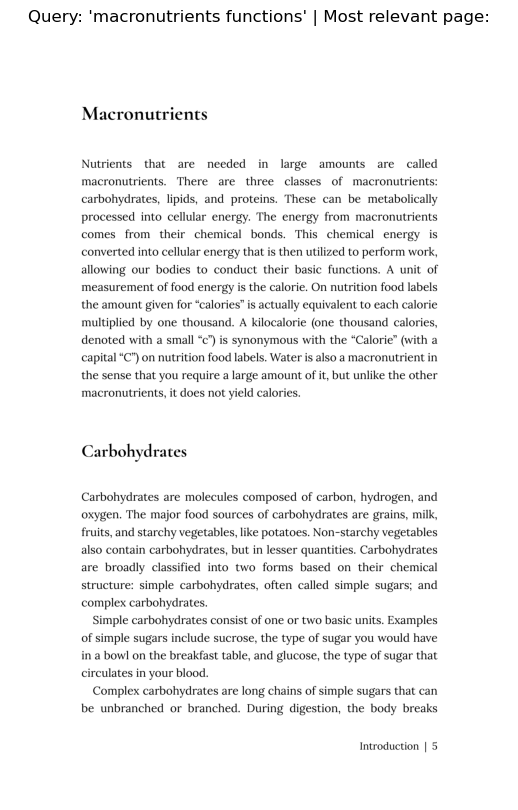

In [58]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [59]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [60]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [61]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

In [62]:

# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with th

### check local GPU mem availability



In [65]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 8 GB


In [67]:
#Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 8 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory 
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    llm_model.to("cuda")

In [ ]:

llm_model

In [ ]:

def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

In [ ]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

In [ ]:

%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

In [ ]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

In [ ]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items